In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
from datetime import datetime, timedelta

In [10]:
#Change the path to the data
place_stocks = "/Users/.../stocks2.csv"
place_fff = "/Users/.../ffm.csv"

In [72]:
start = "2010-09"
end = "2023-09"

In [73]:
def get_fff_returns():
    """
    Load the Fama-French Research Factor Monthly Dataset
    """
    rets = pd.read_csv(place_fff,
                       header=0, index_col=0, na_values=-99.99)/100
    rets.index = pd.to_datetime(rets.index, format="%Y%m")
    return rets

In [74]:
data = pd.read_csv(place_stocks, parse_dates=True, index_col=0) 
data.index = pd.to_datetime(data.index, format="%Y%m")

data = data[data['ticker'].isin(['BX', 'KKR'])]
data.head()

,ticker,close
date,,
2007-06-01,BX,29.27
2007-07-01,BX,24.01
2007-08-01,BX,23.13
2007-09-01,BX,25.08
2007-10-01,BX,25.43


In [75]:
# Calculate returns
data['ret'] = data.groupby('ticker')['close'].pct_change()
data = data.dropna()
data.tail()

,ticker,close,ret
date,,,
2023-06-01,KKR,56.00,0.087590
2023-07-01,KKR,59.38,0.060357
2023-08-01,KKR,62.81,0.057764
2023-09-01,KKR,61.60,-0.019264
2023-10-01,KKR,55.40,-0.100649


In [76]:
fff = get_fff_returns()
fff.tail()

,Mkt-RF,SMB,HML,RF
date,,,,
2023-05-01,0.0035,0.0161,-0.0772,0.0036
2023-06-01,0.0646,0.0154,-0.0026,0.0040
2023-07-01,0.0321,0.0208,0.0411,0.0045
2023-08-01,-0.0239,-0.0316,-0.0106,0.0045
2023-09-01,-0.0524,-0.0251,0.0152,0.0043


In [77]:
bx = data[data['ticker'] =='BX']
bx.drop(['ticker','close'], axis=1, inplace=True)
bx.tail()

/var/folders/l3/fy553ds11cg_sl1h5r1hwzj00000gn/T/ipykernel_2452/968276813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bx.drop(['ticker','close'], axis=1, inplace=True)


,ret
date,
2023-06-01,0.085591
2023-07-01,0.127138
2023-08-01,0.015078
2023-09-01,0.007239
2023-10-01,-0.138044


In [78]:
kkr = data[data['ticker'] =='KKR']
kkr.drop(['ticker','close'], axis=1, inplace=True)
kkr.head()

/var/folders/l3/fy553ds11cg_sl1h5r1hwzj00000gn/T/ipykernel_2452/3893683453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kkr.drop(['ticker','close'], axis=1, inplace=True)


,ret
date,
2010-08-01,0.107182
2010-09-01,0.057884
2010-10-01,0.196226
2010-11-01,-0.007886
2010-12-01,0.128776


In [79]:
#RUN TGIS - Then go manuallt change the start date as thr minimum of these two
print(bx.index.min())
print(kkr.index.min()) #min_index_value_bx = kkr.index.min()

2007-07-01 00:00:00
2010-08-01 00:00:00


In [80]:
mkt_excess = fff.loc[start:end,['Mkt-RF']]
exp_var = mkt_excess.copy()
exp_var["Constant"] = 1

exp_var_capm = exp_var.copy()

exp_var["Value"] = fff.loc[start:end,['HML']]
exp_var["Size"] = fff.loc[start:end,['SMB']]
exp_var.head()

var1 = 'Mkt-RF'
var2 = 'Value'
var3 = 'Size'

In [81]:
grouped_description = data.groupby('ticker').describe()
round(grouped_description.transpose(),3)

ticker            BX      KKR
close count  196.000  159.000
      mean    39.804   28.130
      std     31.763   16.380
      min      4.510   10.020
      25%     16.598   16.720
      50%     31.015   22.510
      75%     49.070   33.025
      max    141.450   79.670
ret   count  196.000  159.000
      mean     0.012    0.015
      std      0.110    0.091
      min     -0.404   -0.201
      25%     -0.046   -0.048
      50%      0.016    0.011
      75%      0.076    0.073
      max      0.489    0.309

In [82]:
grouped_description = fff.describe()
round(grouped_description,3)

,Mkt-RF,SMB,HML,RF
count,1167.000,1167.000,1167.000,1167.000
mean,0.007,0.002,0.003,0.003
std,0.053,0.032,0.036,0.003
min,-0.291,-0.172,-0.139,-0.001
25%,-0.020,-0.016,-0.014,0.000
50%,0.011,0.001,0.001,0.002
75%,0.036,0.018,0.018,0.004
max,0.388,0.366,0.356,0.014


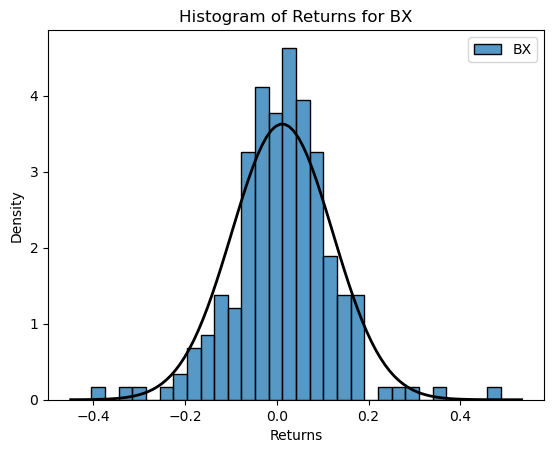

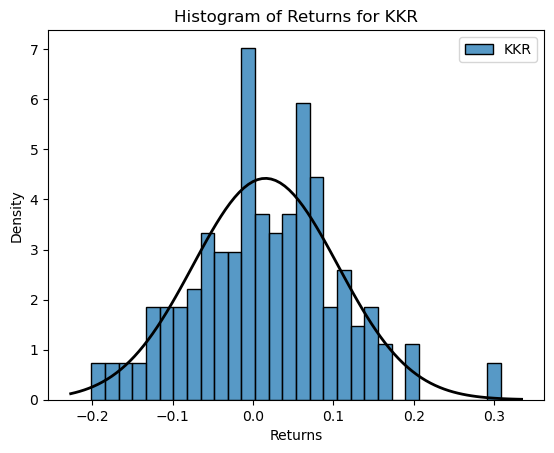

In [83]:
grouped_data = data.groupby('ticker')

for ticker, group in grouped_data:
    sns.histplot(group['ret'], kde=False, stat="density", label=ticker, bins=30)

    mu, std = norm.fit(group['ret'])

    # Plot the normal curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)

    title = f"Histogram of Returns for {ticker}"
    plt.title(title)
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [84]:
skewness = grouped_data['ret'].apply(stats.skew)
kurtosis = grouped_data['ret'].apply(stats.kurtosis)

skewness, kurtosis

(ticker
 BX     0.039413
 KKR    0.162334
 Name: ret, dtype: float64,
 ticker
 BX     2.634218
 KKR    0.388914
 Name: ret, dtype: float64)

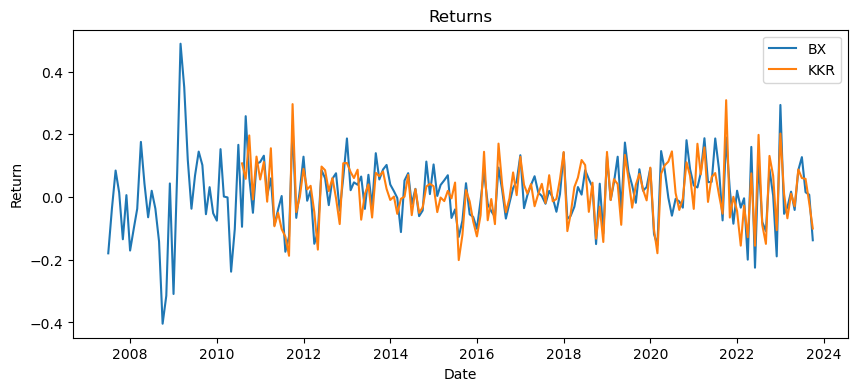

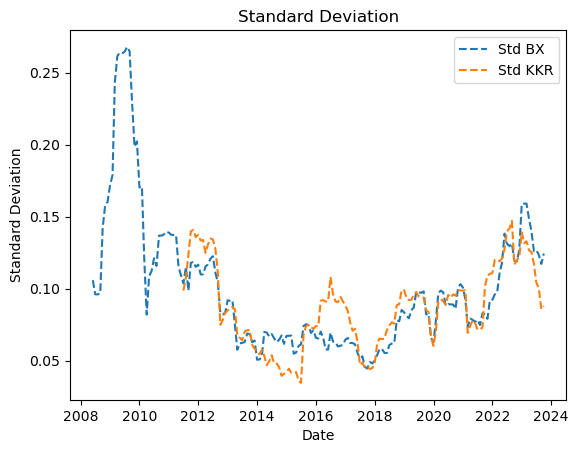

In [85]:
# Plotting mean returns and standard deviation on separate graphs for each ticker

data2 = data[data['ticker'].isin(['BX', 'KKR'])]

mean_returns = data2.groupby(['ticker', 'date'])['ret'].mean().unstack('ticker')

# First, pivot the data to have dates as the index and tickers as the columns
pivoted_data = data2.pivot(columns='ticker', values='ret')

window_size = 12

# Calculate the rolling standard deviation
std_returns = pivoted_data.rolling(window=window_size).std()

# Plotting
plt.figure(figsize=(10, 4))

for ticker in mean_returns.columns:
    plt.plot(mean_returns.index, mean_returns[ticker], label=f'{ticker}')
plt.title('Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

for ticker in std_returns.columns:
    plt.plot(std_returns.index, std_returns[ticker], linestyle='--', label=f'Std {ticker}')
plt.title('Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.legend()
plt.show()



<AxesSubplot:xlabel='date'>

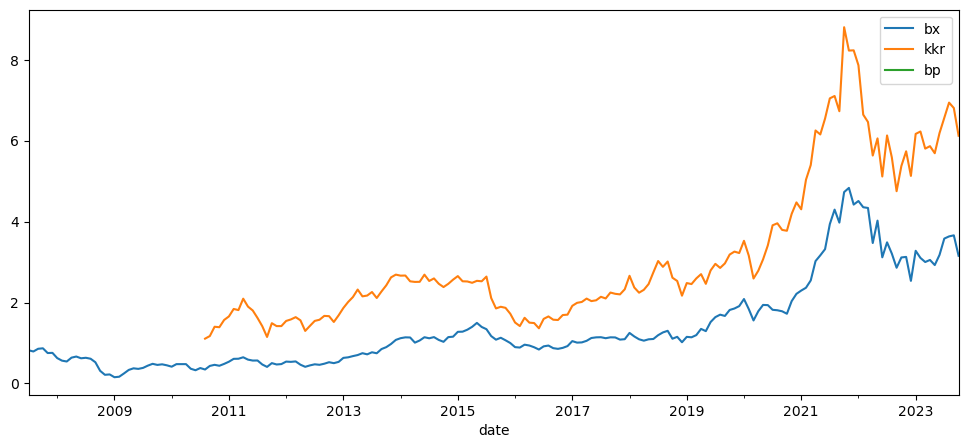

In [86]:
btr = pd.DataFrame({'bx': bx['ret'], 'kkr': kkr['ret'], 'bp': bp['ret']})
(1+btr).cumprod().plot(figsize=(12,5))


## Testing for BX

In [87]:
bx_excess = bx[start:end] - fff.loc[start:end, ['RF']].values

lm = sm.OLS(bx_excess, exp_var_capm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     178.5
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           1.42e-27
Time:                        22:20:37   Log-Likelihood:                 216.93
No. Observations:                 157   AIC:                            -429.9
Df Residuals:                     155   BIC:                            -423.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.5012      0.112     13.360      0.000       1.279       1.723
Constant       0.0023      0.005      0.453      0.651      -0.008       0.012
==============================================================================
Omnibus:                        3.139   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.208   Jarque-Bera (JB):                2.650
Skew:                           0.279   Prob(JB):                        0.266
Kurtosis:                       3.305   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
lm = sm.OLS(bx_excess, exp_var).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     59.22
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           1.82e-25
Time:                        22:20:37   Log-Likelihood:                 217.29
No. Observations:                 157   AIC:                            -426.6
Df Residuals:                     153   BIC:                            -414.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.5241      0.120     12.729      0.000       1.288       1.761
Constant       0.0021      0.005      0.414      0.679      -0.008       0.012
Value          0.0802      0.148      0.543      0.588      -0.211       0.372
Size          -0.1333      0.209     -0.638      0.524      -0.546       0.279
==============================================================================
Omnibus:                        3.111   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.211   Jarque-Bera (JB):                2.634
Skew:                           0.255   Prob(JB):                        0.268
Kurtosis:                       3.377   Cond. No.                         43.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Testing for KKR

In [89]:
kkr_excess = kkr[start:end] - fff.loc[start:end, ['RF']].values

lm = sm.OLS(kkr_excess, exp_var_capm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     214.1
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           5.22e-31
Time:                        22:20:37   Log-Likelihood:                 223.34
No. Observations:                 157   AIC:                            -442.7
Df Residuals:                     155   BIC:                            -436.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.5785      0.108     14.633      0.000       1.365       1.792
Constant      -0.0020      0.005     -0.417      0.677      -0.012       0.008
==============================================================================
Omnibus:                        2.498   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.287   Jarque-Bera (JB):                2.066
Skew:                           0.193   Prob(JB):                        0.356
Kurtosis:                       3.409   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
lm = sm.OLS(kkr_excess, exp_var).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     71.18
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           7.14e-29
Time:                        22:20:37   Log-Likelihood:                 223.81
No. Observations:                 157   AIC:                            -439.6
Df Residuals:                     153   BIC:                            -427.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.6045      0.115     13.970      0.000       1.378       1.831
Constant      -0.0022      0.005     -0.455      0.650      -0.012       0.007
Value          0.0861      0.142      0.608      0.544      -0.194       0.366
Size          -0.1507      0.200     -0.752      0.453      -0.547       0.245
==============================================================================
Omnibus:                        2.375   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.305   Jarque-Bera (JB):                1.922
Skew:                           0.200   Prob(JB):                        0.383
Kurtosis:                       3.365   Cond. No.                         43.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Two periods KKR

In [91]:
start_date = datetime.strptime("2010-09", "%Y-%m")
end_date = datetime.strptime("2023-09", "%Y-%m")

total_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
midpoint_months = total_months // 2
midpoint_date = start_date + timedelta(days=(midpoint_months * 30))  # Approximation using 30 days per month

midpoint = midpoint_date.strftime("%Y-%m")
midpoint


'2017-01'

In [92]:
# Subselect the DataFrame into two parts
bx_excess_h1 = bx_excess[start:midpoint]
bx_excess_h2 = bx_excess[midpoint:end]


In [93]:
exp_var_capm_h1 = exp_var_capm[start:midpoint]
exp_var_capm_h2 = exp_var_capm[midpoint:end]

In [94]:
lm = sm.OLS(bx_excess_h1, exp_var_capm_h1).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     85.68
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           4.85e-14
Time:                        22:20:37   Log-Likelihood:                 111.52
No. Observations:                  77   AIC:                            -219.0
Df Residuals:                      75   BIC:                            -214.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.7271      0.187      9.256      0.000       1.355       2.099
Constant      -0.0038      0.007     -0.542      0.589      -0.018       0.010
==============================================================================
Omnibus:                        0.607   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.738   Jarque-Bera (JB):                0.621
Skew:                           0.203   Prob(JB):                        0.733
Kurtosis:                       2.830   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
lm = sm.OLS(bx_excess_h2, exp_var_capm_h2).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     93.94
Date:                Tue, 28 Nov 2023   Prob (F-statistic):           4.36e-15
Time:                        22:20:38   Log-Likelihood:                 107.69
No. Observations:                  81   AIC:                            -211.4
Df Residuals:                      79   BIC:                            -206.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.4031      0.145      9.692      0.000       1.115       1.691
Constant       0.0075      0.007      1.023      0.309      -0.007       0.022
==============================================================================
Omnibus:                        3.239   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                2.514
Skew:                           0.318   Prob(JB):                        0.285
Kurtosis:                       3.583   Cond. No.                         20.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""